# Creating a collection of CVD and CHD terms

This notebook covers the creation of references terms for CVD and CHD. This is done through the following steps:
1. Creation of a dictionary based on the `Diagnosis` and `Problem List` subject areas
2. Applying `fuzzy` or `spacy` based searches to get suitable thresholds.
3. Implement a search based on a selected threshold.
4. Save the search results and use as dictionary later on for filtering of premature (male <= 55, female <= 65) CVD and CHD.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from dotenv import load_dotenv
load_dotenv("../.env")  # take environment variables
PROJECT_ROOT = os.environ.get("PROJECT_ROOT")
sys.path.append(PROJECT_ROOT)
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from tqdm import tqdm
from datetime import datetime

import utils.PATHS as PATHS
import utils.utils as utils
# import utils.emr_utils as emr_utils
# import utils.load_utils as load_utils

In [3]:
dia_fp_list = glob(os.path.join(PATHS.DIAGNOSIS, "*.csv"))

# general labs dataframe
df_list = [pd.read_csv(path, low_memory=False) for path in tqdm(dia_fp_list)]
dia_df = pd.concat(df_list, ignore_index=True)

100%|█████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.68it/s]


In [4]:
dia_df.columns

Index(['Institution Code', 'Patient ID', 'Gender', 'Race', 'Nationality',
       'Date of Birth', 'Resident Indicator', 'Death Date', 'Diagnosis Code',
       'Diagnosis Description', 'Diagnosis Catalogue Code',
       'Diagnosis Code (ICD10)', 'Diagnosis Description (ICD10)',
       'ILD Indicator (ICD10)', 'Diagnosis Date', 'Case No', 'eHIntS Case Id',
       'Visit No', 'Admit/Visit Date', 'ICD10 Diagnosis Type',
       'ICD10 Diagnosis Type2', 'Diagnosis Creation Date',
       'Diagnosis Catalog Code', 'Diagnosis Catalogue Code.1',
       'Diagnosis Catalogue Text Code', 'Diagnosis Catalogue Text Description',
       'Reference Catalog Code', 'Reference Catalog Description', 'BMI',
       'Height', 'Weight'],
      dtype='object')

In [5]:
prl_fp_list = glob(os.path.join(PATHS.PROBLEM_LIST, "*.csv"))

df_list = []
for path in tqdm(prl_fp_list):
    temp = pd.read_csv(path, low_memory=False)

    # address div block at df tail
    subset = temp.columns.tolist()
    subset.remove("Visit Date")
    temp = temp.dropna(subset=subset, how="all")

    df_list.append(temp)
    
prl_df = pd.concat(df_list, ignore_index=True)

100%|█████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.52s/it]


In [6]:
prl_df.columns

Index(['Visit Date', 'Institution', 'Case No', 'Visit No', 'Patient ID',
       'Date of Birth', 'Race', 'Gender', 'Resident Indicator', 'Nationality',
       'Problem Serial No', 'Problem Summary', 'Problem Code (Coded)',
       'Problem Desc (Coded)', 'Coding Scheme (Coded)',
       'Problem Shortname (Coded)', 'Problem Status', 'Problem Onset (Day)',
       'Problem Onset (Month)', 'Problem Onset (Year)', 'Created Date',
       'Entered Date', 'Resolved Date', 'Updated Date', 'Smoking',
       'Smoking History', 'Smoking History.1'],
      dtype='object')

## Create dictionary

### Diagnosis

In [7]:
dia_dict = dia_df[['Diagnosis Code (ICD10)', 'Diagnosis Description (ICD10)']].drop_duplicates()

### Problem List

In [8]:
prl_dict = prl_df[['Problem Code (Coded)', 'Problem Desc (Coded)', 'Coding Scheme (Coded)']].drop_duplicates()

## Thresholds EDA

### Semantic similarity with `spaCy`

SpaCy `Doc.vector` are averages of per token vectors. As stated in this documentation [link](https://spacy.io/api/doc#vector).
> "A real-valued meaning representation. Defaults to an average of the token vectors."

Similarity is calculated as [cosine similarity using an average of word vectors.](https://spacy.io/api/doc#similarity)

In [9]:
import spacy

In [10]:
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_sm

In [11]:
nlp = spacy.load("en_core_web_md")
# spacy.prefer_gpu()
def get_similarity(term1, term2):
    """Get similarity using an NLP model."""
    if len(term2) == 0:
        return 0
    term1_vec = nlp(term1)
    term2_vec = nlp(term2)
    return term1_vec.similarity(term2_vec)

In [12]:
tqdm.pandas()
key_term = utils.cvd_terms[0].lower()
db_terms = dia_dict['Diagnosis Description (ICD10)'].str.lower()
sims = db_terms.progress_apply(lambda x: get_similarity(key_term, x))

  2%|█▎                                                  | 75/3013 [00:00<00:16, 176.01it/s]/tmp/ipykernel_264253/1688029613.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return term1_vec.similarity(term2_vec)
100%|██████████████████████████████████████████████████| 3013/3013 [00:17<00:00, 170.19it/s]


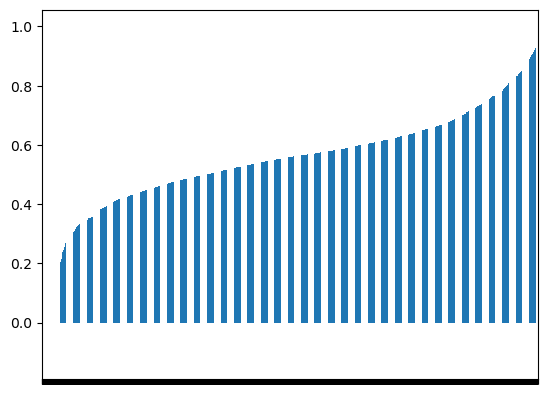

In [13]:
fig, ax = plt.subplots()
sims.sort_values().plot.bar(ax=ax)
ax.set_xticklabels([])
plt.show()

In [14]:
# sample terms
threshold = 0.99
dia_dict[sims >= threshold]

,Diagnosis Code (ICD10),Diagnosis Description (ICD10)
470,J051,Acute epiglottitis
2998,D471,Chronic myeloproliferative disease
50057,N03,Chronic nephritic syndrome
65801,H701,Chronic mastoiditis
129728,J041,Acute tracheitis
221831,J311,Chronic nasopharyngitis


### Fuzzy Similarity with `thefuzz`

In [15]:
from thefuzz import fuzz

In [16]:
# Check the similarity score
def get_fuzz_similarity(term1, term2):
    """Get similarity using an NLP model."""
    if len(term2) == 0:
        return 0
    return fuzz.token_set_ratio(term1, term2)

In [17]:
tqdm.pandas()
key_term = utils.cvd_terms[0].lower()
db_terms = dia_dict['Diagnosis Description (ICD10)'].str.lower()
sims = db_terms.progress_apply(lambda x: get_fuzz_similarity(key_term, x)) / 100

100%|███████████████████████████████████████████████| 3013/3013 [00:00<00:00, 167714.27it/s]


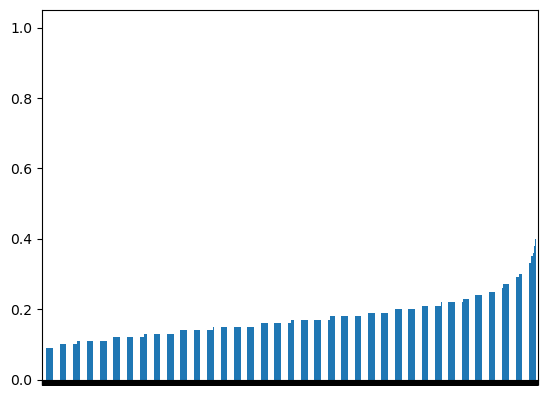

In [18]:
fig, ax = plt.subplots()
sims.sort_values().plot.bar(ax=ax)
ax.set_xticklabels([])
plt.show()

In [42]:
# sample terms
threshold = 0.8
dia_dict[sims >= threshold]

,Diagnosis Code (ICD10),Diagnosis Description (ICD10)
565,I64,"Stroke, not specified as haemorrhage orinfarction"
183631,I694,"Sequelae of stroke, not specified as haemorrha..."


### Contains method

In [30]:
key_term = utils.cvd_terms[0].lower()
db_terms = dia_dict['Diagnosis Description (ICD10)'].str.lower()
matches = dia_dict[db_terms.str.contains(key_term)]
matches

,Diagnosis Code (ICD10),Diagnosis Description (ICD10)
565,I64,"Stroke, not specified as haemorrhage orinfarction"
183631,I694,"Sequelae of stroke, not specified as haemorrha..."


## Candidate `CVD`-related Terms from `Diagnosis` subject area

Candidate terms are generated uzing threholded token set ratio implemented by `thefuzz.fuzz`.

In [57]:
db_terms = dia_dict['Diagnosis Description (ICD10)'].str.lower()
threshold = 0.8
logger_reference = dia_dict.copy()

candidate_list = []
for key_term in tqdm(utils.cvd_terms + utils.cvd_procedure_terms):
    sims = db_terms.apply(
        lambda x: get_fuzz_similarity(key_term.lower(), x)
    ) / 100
    temp = logger_reference.copy()
    temp['Score'] = sims
    temp['Key Term'] = key_term
    temp = temp[temp["Score"] >= threshold]
    candidate_list.append(temp)

candidate_terms = pd.concat(candidate_list, axis=0, ignore_index=True)

100%|███████████████████████████████████████████████████████| 52/52 [00:01<00:00, 50.65it/s]


In [58]:
candidate_terms

,Diagnosis Code (ICD10),Diagnosis Description (ICD10),Score,Key Term
0,I64,"Stroke, not specified as haemorrhage orinfarction",1.00,Stroke
1,I694,"Sequelae of stroke, not specified as haemorrha...",1.00,Stroke
2,I639,"Cerebral infarction, unspecified",1.00,Cerebral Infarction
3,I632,Cerebral infarction due to unspecified occlusi...,1.00,Cerebral Infarction
4,I631,Cerebral infarction due to embolism of precere...,1.00,Cerebral Infarction
5,I635,Cerebral infarction due to unspecified occlusi...,1.00,Cerebral Infarction
6,I634,Cerebral infarction due to embolism of cerebra...,1.00,Cerebral Infarction
7,I693,Sequelae of cerebral infarction,1.00,Cerebral Infarction
8,S066,Traumatic subarachnoid haemorrhage,0.81,Subarachnoid Hemorrhage
9,I618,Other intracerebral haemorrhage,0.87,Intracerebral Hemorrhage


## Candidate `CVD`-related Terms from `Problem List` subject area
Candidate terms are generated uzing threholded token set ratio implemented by `thefuzz.fuzz`.

In [59]:
db_terms = prl_dict['Problem Desc (Coded)'].str.lower()
threshold = 0.8
logger_reference = prl_dict.copy()

candidate_list = []
for key_term in tqdm(utils.cvd_terms + utils.cvd_procedure_terms):
    sims = db_terms.apply(
        lambda x: get_fuzz_similarity(key_term.lower(), x)
    ) / 100
    temp = logger_reference.copy()
    temp['Score'] = sims
    temp['Key Term'] = key_term
    temp = temp[temp["Score"] >= threshold]
    candidate_list.append(temp)

candidate_terms = pd.concat(candidate_list, axis=0, ignore_index=True)

100%|███████████████████████████████████████████████████████| 52/52 [00:09<00:00,  5.36it/s]


In [60]:
candidate_terms

,Problem Code (Coded),Problem Desc (Coded),Coding Scheme (Coded),Score,Key Term
0,345636015,STROKE,SN,1.00,Stroke
1,2966565019,POSTERIOR CEREBRAL CIRCULATION STROKE,SN,1.00,Stroke
2,2476091017,H/O: STROKE,SN,1.00,Stroke
3,345652017,LACUNAR STROKE,SN,1.00,Stroke
4,2644233012,ISCHEMIC STROKE,SN,1.00,Stroke
...,...,...,...,...,...
548,3006055015,HEART TRANSPLANT RECIPIENT,SN,1.00,Heart Transplant
549,135219015,TRANSPLANTED HEART,SN,0.94,Heart Transplant
550,3006055015,HEART TRANSPLANT RECIPIENT*,SN,1.00,Heart Transplant
551,35387012,HAIR TRANSPLANT,SP,0.90,Heart Transplant


## `CHD` Candidate Terms from `Diagnosis` subject area

Candidate terms are generated uzing threholded token set ratio implemented by `thefuzz.fuzz`.

In [61]:
db_terms = dia_dict['Diagnosis Description (ICD10)'].str.lower()
threshold = 0.8
logger_reference = dia_dict.copy()

candidate_list = []
for key_term in tqdm(utils.chd_terms + utils.chd_procedure_terms):
    sims = db_terms.apply(
        lambda x: get_fuzz_similarity(key_term.lower(), x)
    ) / 100
    temp = logger_reference.copy()
    temp['Score'] = sims
    temp['Key Term'] = key_term
    temp = temp[temp["Score"] >= threshold]
    candidate_list.append(temp)

candidate_terms = pd.concat(candidate_list, axis=0, ignore_index=True)

100%|███████████████████████████████████████████████████████| 61/61 [00:01<00:00, 53.94it/s]


In [62]:
candidate_terms

,Diagnosis Code (ICD10),Diagnosis Description (ICD10),Score,Key Term
0,Q2110,Unspecified atrial septal defect,1.00,Atrial Septal Defect
1,Q2100,Unspecified ventricular septal defect,1.00,Ventricular Septal Defect
2,Q250,Patent ductus arteriosus,1.00,Patent Ductus Arteriosus
3,Q2242,Congenital tricuspid atresia,1.00,Tricuspid Atresia
4,I350,Aortic (valve) stenosis,1.00,Aortic Valve Stenosis
5,I350,Aortic (valve) stenosis,0.80,Pulmonary Valve Stenosis
6,I340,Mitral (valve) insufficiency,0.84,Congenital Aortic Valve Insufficiency
7,I351,Aortic (valve) insufficiency,1.00,Congenital Aortic Valve Insufficiency
8,Q233,Congenital mitral insufficiency,0.87,Congenital Aortic Valve Insufficiency
9,I340,Mitral (valve) insufficiency,0.84,Congenital Pulmonary Valve Insufficiency


## `CHD` Candidate Terms from `Problem List` subject area
Candidate terms are generated uzing threholded token set ratio implemented by `thefuzz.fuzz`.

In [63]:
db_terms = prl_dict['Problem Desc (Coded)'].str.lower()
threshold = 0.8
logger_reference = prl_dict.copy()

candidate_list = []
for key_term in tqdm(utils.chd_terms + utils.chd_procedure_terms):
    sims = db_terms.apply(
        lambda x: get_fuzz_similarity(key_term.lower(), x)
    ) / 100
    temp = logger_reference.copy()
    temp['Score'] = sims
    temp['Key Term'] = key_term
    temp = temp[temp["Score"] >= threshold]
    candidate_list.append(temp)

candidate_terms = pd.concat(candidate_list, axis=0, ignore_index=True)

100%|███████████████████████████████████████████████████████| 61/61 [00:11<00:00,  5.20it/s]


In [64]:
candidate_terms

,Problem Code (Coded),Problem Desc (Coded),Coding Scheme (Coded),Score,Key Term
0,116491019,ATRIAL SEPTAL DEFECT,SN,1.00,Atrial Septal Defect
1,190493015,CLOSURE OF ATRIAL SEPTAL DEFECT,SP,1.00,Atrial Septal Defect
2,313309018,ASD II - SECUNDUM ATRIAL SEPTAL DEFECT,SN,1.00,Atrial Septal Defect
3,501497015,ASD - ATRIAL SEPTAL DEFECT,SN,1.00,Atrial Septal Defect
4,376943012,ASD - REPAIR OF ATRIAL SEPTAL DEFECT,SP,1.00,Atrial Septal Defect
...,...,...,...,...,...
517,3006055015,HEART TRANSPLANT RECIPIENT,SN,1.00,Heart Transplant
518,135219015,TRANSPLANTED HEART,SN,0.94,Heart Transplant
519,3006055015,HEART TRANSPLANT RECIPIENT*,SN,1.00,Heart Transplant
520,35387012,HAIR TRANSPLANT,SP,0.90,Heart Transplant


## End